<a href="https://colab.research.google.com/github/PashaLikhterov/Deep-Learning/blob/main/Assignment3_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3: Image Classification

In this assignment, we will build a convolutional neural network that can predict 
whether two shoes are from the **same pair** or from two **different pairs**.
This kind of application can have real-world applications: for example to help
people who are visually impaired to have more independence.

We will explore two convolutional architectures. While we will give you starter
code to help make data processing a bit easier, in this assignment you have a chance to build your neural network all by yourself. 

You may modify the starter code as you see fit, including changing the signatures of
functions and adding/removing helper functions. However, please make sure that we can understand what you are doing and why.
 

In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataloader import DataLoader
device = torch.device("cpu") 


In [ ]:
device

device(type='cpu')

## Question 1. Data (20%)

Download the data from the course website. 

Unzip the file. There are three
main folders: `train`, `test_w` and `test_m`. Data in `train` will be used for
training and validation, and the data in the other folders will be used for testing.
This is so that the entire class will have the same test sets. The dataset is comprised of triplets of pairs, where each such triplet of image pairs was taken in a similar setting (by the same person).

We've separated `test_w` and `test_m` so that we can track our model performance 
for women's shoes and men's shoes separately. Each of the test sets contain images of either exclusively men's shoes or women's
shoes.

Upload this data to Google Colab.
Then, mount Google Drive from your Google Colab notebook:

In [2]:
from google.colab import drive
#drive.mount('/content/gdrive/My Drive/Intro_to_Deep_Learning/assignment3')
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


After you have done so, read this entire section 
before proceeding. There are right and wrong ways of
processing this data. If you don't make the correct choices, you may find
yourself needing to start over.
Many machine learning projects fail because of the lack of care taken during
the data processing stage.

### Part (a) -- 8%

Load the training and test data, and separate your training data into training and validation.
Create the numpy arrays `train_data`, `valid_data`, `test_w` and `test_m`, all of which should
be of shape `[*, 3, 2, 224, 224, 3]`. The dimensions of these numpy arrays are as follows:

- `*` - the number of triplets allocated to train, valid, or test
- `3` - the 3 pairs of shoe images in that triplet
- `2` - the left/right shoes
- `224` - the height of each image
- `224` - the width of each image
- `3` - the colour channels

So, the item `train_data[4,0,0,:,:,:]` should give us the left shoe of the first image of the fifth person.The item `train_data[4,0,1,:,:,:]`  should be the right shoe in the same pair. 
The item `train_data[4,1,1,:,:,:]`  should be the right shoe in a different pair of that same person.

When you first load the images using (for example) `plt.imread`, you may see a numpy array of shape
`[224, 224, 4]` instead of `[224, 224, 3]`. That last channel is what's called the alpha channel for transparent
pixels, and should be removed. 
The pixel intensities are stored as an integer between 0 and 255.
Make sure you normlize your images, namely, divide the intensities by 255 so that you have floating-point values between 0 and 1. Then, subtract 0.5
so that the elements of `train_data`, `valid_data` and `test_data` are between -0.5 and 0.5.
**Note that this step actually makes a huge difference in training!**

This function might take a while to run; it can takes several minutes to just
load the files from Google Drive.  If you want to avoid
running this code multiple times, you can save 
your numpy arrays and load it later:
https://docs.scipy.org/doc/numpy/reference/generated/numpy.save.html

In [ ]:
from time import thread_time_ns
# Your code goes here. Make sure it does not get cut off
# You can use the code below to help you get started. You're welcome to modify
# the code or remove it entirely: it's just here so that you don't get stuck
# reading files

import glob
path_train = "/content/gdrive/My Drive/Intro_to_Deep_Learning/assignment3/data/train/*.jpg" # TODO - UPDATE ME!
path_testw = "/content/gdrive/My Drive/Intro_to_Deep_Learning/assignment3/data/test_w/*.jpg"
path_testm = "/content/gdrive/My Drive/Intro_to_Deep_Learning/assignment3/data/test_m/*.jpg"

#print(train_images.keys())
  
def prepare_data(file_path):
  data_images = {}
  for file in glob.glob(file_path):
      filename = file.split("/")[-1]   # get the name of the .jpg file
      img = plt.imread(file)                 # read the image as a numpy array
      img = (img/255) - 0.5
      data_images[filename] = img[:, :, :3] # remove the alpha channel


  sort_data = dict(sorted(data_images.items()))
  data_list = np.array(list(sort_data.values()))
  return data_list


train = prepare_data(path_train)
train = np.reshape(train, (112,3,2,224,224,3))
valid_data, train_data = train[92:], train[:92] #valid is ~20% of the train data

test_m = prepare_data(path_testm)
test_m_data = np.reshape(test_m, (10,3,2,224,224,3))

test_w = prepare_data(path_testw)
test_w_data = np.reshape(test_w, (10,3,2,224,224,3))


folder_path = "/content/gdrive/My Drive/Intro_to_Deep_Learning/assignment3"
with open(f'{folder_path}/data.npy', 'wb') as data:
  np.save(data, train_data)
  np.save(data, valid_data)
  np.save(data, test_m_data)
  np.save(data, test_w_data)

In [3]:
folder_path = "/content/gdrive/My Drive/Intro_to_Deep_Learning/assignment3"
with open(f'{folder_path}/data.npy', 'rb') as data:
  train_data = np.load(data)
  valid_data = np.load(data)
  test_m_data = np.load(data)
  test_w_data = np.load(data)

In [ ]:

# lets take 20% for validation
print(np.shape(train_data))
print(np.shape(valid_data))

(92, 3, 2, 224, 224, 3)
(20, 3, 2, 224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


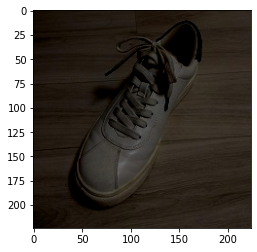

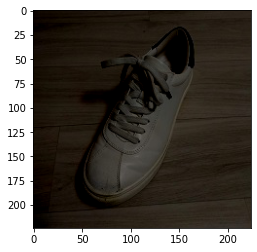

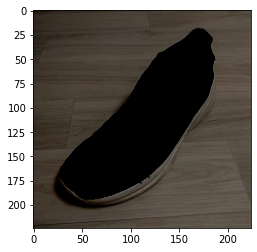

In [ ]:
# Run this code, include the image in your PDF submission
plt.figure()
plt.imshow(train_data[4,0,0,:,:,:]) # left shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,0,1,:,:,:]) # right shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[4,1,1,:,:,:]) # right shoe of second pair submitted by 5th student

### Part (b) -- 4%

Since we want to train a model that determines whether two shoes come from the **same**
pair or **different** pairs, we need to create some labelled training data.
Our model will take in an image, either consisting of two shoes from the **same pair**
or from **different pairs**. So, we'll need to generate some *positive examples* with
images containing two shoes that *are* from the same pair, and some *negative examples* where 
images containing two shoes that *are not* from the same pair.
We'll generate the *positive examples* in this part, and the *negative examples* in the next part.

Write a function `generate_same_pair()` that takes one of the data sets that you produced
in part (a), and generates a numpy array where each pair of shoes in the data set is
concatenated together. In particular, we'll be concatenating together images of left
and right shoes along the **height** axis. Your function `generate_same_pair` should
return a  numpy array of shape `[*, 448, 224, 3]`.

While at this stage we are working with numpy arrays, later on, we will need to convert this numpy array into a PyTorch tensor with shape
`[*, 3, 448, 224]`. For now, we'll keep the RGB channel as the last dimension since
that's what `plt.imshow` requires.

(92, 3, 2, 224, 224, 3)
(276, 448, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


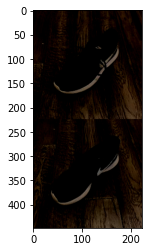

In [4]:
# Your code goes here
def generate_same_pair(data):
  same_pair = []
  for index in range(len(data)):
    for j in range(data.shape[1]):
      pic1 = data[index,j,0,:,:,:]
      pic2 = data[index,j,1,:,:,:]
      pic_concat = np.concatenate((pic1, pic2), axis=0)
      same_pair.append(pic_concat)
  same_pair = np.array(same_pair)
  return same_pair

# Run this code, include the result with your PDF submission
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_same_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_same_pair(train_data)[0]) # should show 2 shoes from the same pair

### Part (c) -- 4%

Write a function `generate_different_pair()` that takes one of the data sets that
you produced in part (a), and generates a numpy array in the same shape as part (b).
However, each image will contain 2 shoes from a **different** pair, but submitted
by the **same student**. Do this by jumbling the 3 pairs of shoes submitted by 
each student.

Theoretically, for each person (triplet of pairs), there are 6 different combinations
of "wrong pairs" that we could produce. To keep our data set *balanced*, we will
only produce **three** combinations of wrong pairs per unique person.
In other words,`generate_same_pairs` and `generate_different_pairs` should
return the same number of training examples.

(92, 3, 2, 224, 224, 3)
(276, 448, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


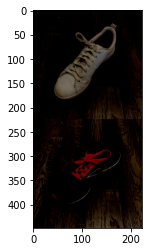

In [5]:
def generate_different_pair(data):
  different_pair = []
  for index in range(len(data)):
    for j in range(train_data.shape[2]):
      pic1 = data[index,0,j,:,:,:]
      pic2 = data[index,1,j,:,:,:]
      pic3 = data[index,2,j,:,:,:]
      pic_concat = np.concatenate((pic1, pic2), axis=0)
      different_pair.append(pic_concat)
    pic_concat1 = np.concatenate((pic2, pic3), axis=0)
    different_pair.append(pic_concat1)
  different_pair = np.array(different_pair)
  return different_pair
# Run this code, include the result with your PDF submission
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_different_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_different_pair(train_data)[2]) # should show 2 shoes from different pairs

### Part (d) -- 2%

Why do we insist that the different pairs of shoes still come from the same
person?  (Hint: what else do images from the same person have in common?)

**Write your explanation here:**
The model takes into acout not just the shoe, its also takes into the acount features like, background light and color, show angel. For the same person all those features are approximately the same, meaning the model will need to learn more (concetrateon the shoes) to tell the difference. 

### Part (e) -- 2%

Why is it important that our data set be *balanced*? In other words suppose we created
a data set where 99% of the images are of shoes that are *not* from the same pair, and 
1% of the images are shoes that *are* from the same pair. Why could this be a problem?

**Write your explanation here:**
We want our dataset to be balanced in order to give the same priority to each class (same pair, different pair). If we wont do this the training results might be good for the class that got more of the data, but in real life examples or in the test we will see pureresults with the smaller dataset class.

## Question 2. Convolutional Neural Networks (25%)

Before starting this question, we recommend reviewing the lecture and its associated example notebook on CNNs.

In this section, we will build two CNN models in PyTorch.

### Part (a) -- 9%

Implement a CNN model in PyTorch called `CNN` that will take images of size
$3 \times 448 \times 224$, and classify whether the images contain shoes from
the same pair or from different pairs.

The model should contain the following layers:

- A convolution layer that takes in 3 channels, and outputs $n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A second convolution layer that takes in $n$ channels, and outputs $2\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A third convolution layer that takes in $2\cdot n$ channels, and outputs $4\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fourth convolution layer that takes in $4\cdot n$ channels, and outputs $8\cdot n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fully-connected layer with 100 hidden units
- A fully-connected layer with 2 hidden units

Make the variable $n$ a parameter of your CNN. You can use either $3 \times 3$ or $5 \times 5$
convolutions kernels. Set your padding to be `(kernel_size - 1) / 2` so that your feature maps
have an even height/width.

Note that we are omitting in our description certain steps that practitioners will typically not mention,
like ReLU activations and reshaping operations. Use the example presented in class to figure out where they are.

In [6]:
class CNN(nn.Module):
    def __init__(self, n=4):
        super(CNN, self).__init__()
        # TODO: complete this method
        self.n = n
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=n, kernel_size=5,stride=1,padding=2)
        self.conv2 = nn.Conv2d(in_channels=n,out_channels=2*n, kernel_size=5,stride =1, padding=2)
        self.conv3 = nn.Conv2d(in_channels=2*n, out_channels=4*n, kernel_size=5, stride =1,padding=2)
        self.conv4 = nn.Conv2d(in_channels=4*n,out_channels=8*n, kernel_size=5,stride =1, padding=2)
        self.fc1 = nn.Linear(8*n*28*14, 100)
        self.fc2 = nn.Linear(100, 2)

    # TODO: complete this class
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = self.conv3(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = self.conv4(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1,8*self.n*28*14)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return x

### Part (b) -- 8%

Implement a CNN model in PyTorch called `CNNChannel` that contains the same layers as
in the Part (a), but with one crucial difference: instead of starting with an image
of shape $3 \times 448 \times 224$, we will first manipulate the image so that the
left and right shoes images are concatenated along the **channel** dimension.

<img src="https://drive.google.com/uc?id=1B59VE43X-6Dw3ag-9Ndn6vPEzbnFem8K" width="400px" />


Complete the manipulation in the `forward()` method (by slicing and using
the function `torch.cat`). The input to the first convolutional layer
should have 6 channels instead of 3 (input shape $6 \times 224 \times 224$).

Use the same hyperparameter choices as you did in part (a), e.g. for the kernel size,
choice of downsampling, and other choices.

In [7]:
class CNNChannel(nn.Module):
    def __init__(self, n=4):
        super(CNNChannel, self).__init__()
        # TODO: complete this method
        self.n = n
        self.conv1 = nn.Conv2d(in_channels=6, out_channels=n, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=n, out_channels=2*n, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(in_channels=2*n, out_channels=4*n, kernel_size=5, stride=1, padding=2)
        self.conv4 = nn.Conv2d(in_channels=4*n, out_channels=8*n, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(14*14*8*n, 100)
        self.fc2 = nn.Linear(100, 2)

    # TODO: complete this class
    def forward(self, xs, verbose=False):
      x = torch.cat((xs[:,:,:,:224], xs[:,:,:,224:]), 1)
      x = self.conv1(x)
      x - nn.functional.relu(x)
      x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
      x = self.conv2(x)
      x = nn.functional.relu(x)
      x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
      x = self.conv3(x)
      x = nn.functional.relu(x)
      x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
      x = self.conv4(x)
      x = nn.functional.relu(x)
      x = nn.functional.max_pool2d(x, kernel_size=2, stride=2)
      x = x.view(-1, self.n*8*14*14)
      x = self.fc1(x)
      x = nn.functional.relu(x)
      x = self.fc2(x)
      return x


## Part (c) -- 4%

The two models are quite similar, and should have almost the same number of parameters.
However, one of these models will perform better, showing that architecture choices **do**
matter in machine learning. Explain why one of these models performs better.

**Write your explanation here:**
Like Nir said in one of his lectures, deeper models most often performs better so we excpect the second one performs better.

## Part (d) -- 4%

The function `get_accuracy` is written for you. You may need to modify this
function depending on how you set up your model and training.

Unlike in the previous assignment, her we will separately compute the model accuracy on the
positive and negative samples.  Explain why we may wish to track the false positives and false negatives separately.

**Write your explanation here:**
When saying false negative means we made a mistake by saying that the shoes arent the same when the are the same, its less of a mistake than saying that the pair is matching when its not. 

In [10]:
def get_accuracy(model, data, batch_size=50):
    """Compute the model accuracy on the data set. This function returns two
    separate values: the model accuracy on the positive samples,
    and the model accuracy on the negative samples.

    Example Usage:

    >>> model = CNN() # create untrained model
    >>> pos_acc, neg_acc= get_accuracy(model, valid_data)
    >>> false_positive = 1 - pos_acc
    >>> false_negative = 1 - neg_acc
    """

    model.eval()
    n = data.shape[0]

    data_pos = generate_same_pair(data)      # should have shape [n * 3, 448, 224, 3]
    data_neg = generate_different_pair(data) # should have shape [n * 3, 448, 224, 3]

    pos_correct = 0
    for i in range(0, len(data_pos), batch_size):
        xs = torch.Tensor(data_pos[i:i+batch_size], device=device).transpose(1, 3)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        pos_correct += (pred == 1).sum()
    
    neg_correct = 0
    for i in range(0, len(data_neg), batch_size):
        xs = torch.Tensor(data_neg[i:i+batch_size],device=device).transpose(1, 3)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        neg_correct += (pred == 0).sum()

    return pos_correct / (n * 3), neg_correct / (n * 3)

## Question 3. Training (40%)

Now, we will write the functions required to train the model. 

Although our task is a binary classification problem, we will still use the architecture
of a multi-class classification problem. That is, we'll use a one-hot vector to represent
our target (like we did in the previous assignment). We'll also use `CrossEntropyLoss` instead of
`BCEWithLogitsLoss` (this is a standard practice in machine learning because
this architecture often performs better).

### Part (a) -- 22%

Write the function `train_model` that takes in (as parameters) the model, training data,
validation data, and other hyperparameters like the batch size, weight decay, etc.
This function should be somewhat similar to the training code that you wrote
in Assignment 2, but with a major difference in the way we treat our training data.

Since our positive (shoes of the same pair) and negative (shoes of different pairs) training sets are separate, it is actually easier for
us to generate separate minibatches of positive and negative training data.
 In
each iteration, we'll take `batch_size / 2` positive samples and `batch_size / 2`
negative samples. We will also generate labels of 1's for the positive samples,
and 0's for the negative samples.

Here is what your training function should include:

- main training loop; choice of loss function; choice of optimizer
- obtaining the positive and negative samples
- shuffling the positive and negative samples at the start of each epoch
- in each iteration, take `batch_size / 2` positive samples and `batch_size / 2` negative samples
  as our input for this batch
- in each iteration, take `np.ones(batch_size / 2)` as the labels for the positive samples, and 
  `np.zeros(batch_size / 2)` as the labels for the negative samples
- conversion from numpy arrays to PyTorch tensors, making sure that the input has dimensions $N \times C \times H \times W$ (known as NCHW tensor), where $N$ is the number of images batch size, $C$ is the number of channels, $H$ is the height of the image, and $W$ is the width of the image. 
- computing the forward and backward passes 
- after every epoch, report the accuracies for the training set and validation set
- track the training curve information and plot the training curve

It is also recommended to checkpoint your model (save a copy) after every epoch, as we did in Assignment 2.

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
class DevicedataLoader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
        def __iter__(self):
            for b in self.dl:
              yield to_device(b, self.device)
    def __len__(self):
        return len(self.dl)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data,batch_size=64, shuffle=True)
print(train_loader.dataset.__len__())
print(test_loader.dataset.__len__())

In [8]:
def train(model,
          train_data, validation_data,
          batch_size=64, learning_rate=1e-5, weight_decay=0, max_iters=50,
          checkpoint_path=None):
  

  #First we shall prepare the data sets
  train_data_pos = generate_same_pair(train_data)           # [n * 3, 448, 224, 3]
  train_data_neg = generate_different_pair(train_data)      # [n * 3, 448, 224, 3]
  valid_data_pos = generate_same_pair(validation_data)      # [n * 3, 448, 224, 3]
  valid_data_neg = generate_different_pair(validation_data) # [n * 3, 448, 224, 3]


  print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
  print(train_data_pos.shape)
  print(train_data_neg.shape)
  print(f"The batch size is: {batch_size}")

  train_acc, val_acc, pos_train_acc, neg_train_acc, pos_val_acc, neg_val_acc = [], [] ,[], [], [], []
  iters =[]
  sub = []
  losses = []

  labels_data_pos = np.ones(len(train_data_pos)).astype(int)
  labels_data_neg = np.zeros(len(train_data_neg)).astype(int)
  all_labels = np.concatenate((labels_data_pos, labels_data_neg), axis=0)

  #Model params choice of optimizer and choice of loss function
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  val_acc_value, pos_val_acc_num, pos_val_acc_num, neg_val_acc_num = 0,0,0,0
  train_acc_value, pos_train_acc_num, neg_train_acc_num, train_cost = 0,0,0,0
  #Main loop
  n=0
  for n in range(0, max_iters+1):
     #shuffling the positive and negative samples at the start of each epoch
     reindex = np.random.permutation(len(train_data_pos))
     train_data_pos = train_data_pos[reindex]
     train_data_neg = train_data_neg[reindex]
     labels_data_pos = labels_data_pos[reindex]
     labels_data_neg = labels_data_neg[reindex]
     for iter2, i in enumerate(range(0, len(train_data_pos), batch_size)):
       if(i+batch_size > train_data_pos.shape[0]):
         break
        #in each iteration, take np.ones(batch_size / 2)
        #as the labels for the positive samples, and np.zeros(batch_size / 2) as the labels for the negative samples
       label_data_pos = torch.Tensor(labels_data_pos[i:i+batch_size//2], device=device).long()
       pos_xs = torch.Tensor(train_data_pos[i:i+batch_size//2], device=device).transpose(1, 3)
       label_data_neg = torch.Tensor(labels_data_neg[i:i+batch_size//2], device=device).long()
       neg_xs = torch.Tensor(train_data_neg[i:i+batch_size//2], device=device).transpose(1, 3)
       labels = torch.cat((label_data_pos, label_data_neg), 0)
       xs = torch.cat((pos_xs, neg_xs), 0)

       #xs, labels = xs.to(device), labels.to(device)
       optimizer.zero_grad()
       zs = model(xs)
       loss = criterion(zs, labels)
       loss.backward()
       optimizer.step()

       iters.append(n)
       losses.append(float(loss)/(batch_size))
       train_cost = loss.item()
       #Accurcy for training
       pos_train_acc_num, neg_train_acc_num = get_accuracy(model, train_data, batch_size)
       pos_train_acc.append(pos_train_acc_num)
       neg_train_acc.append(neg_train_acc_num)
       false_pos_train = 1 - pos_train_acc_num
       false_neg_train = 1 - neg_train_acc_num
       train_acc_value = (pos_train_acc_num + neg_train_acc_num)/(pos_train_acc_num + neg_train_acc_num + false_pos_train + false_neg_train)
       train_acc.append(train_acc_value)

      
      #Validation time!
       if n%5==0:
        sub.append(n) 
        #Acurracy for validation
        pos_val_acc_num, neg_val_acc_num = get_accuracy(model, valid_data, batch_size)
        pos_val_acc.append(pos_val_acc_num)
        neg_val_acc.append(neg_val_acc_num)
        false_pos_val = 1 - pos_val_acc_num
        false_neg_val= 1 - neg_val_acc_num
        val_acc_value = (pos_val_acc_num + neg_val_acc_num)/(pos_val_acc_num + neg_val_acc_num + false_pos_val + false_neg_val)
        val_acc.append(val_acc_value)
     print("epoch %d: [Val acc %.0f%%, Pos val Acc %.0f%%, Neg val Acc %.0f%%]\
        [Train acc %.0f%% ,Pos train Acc %.0f%%, Neg train Acc %.0f%% , loss %f]" % 
        (n, val_acc_value * 100, pos_val_acc_num * 100, neg_val_acc_num * 100,
         train_acc_value * 100, pos_train_acc_num * 100, neg_train_acc_num * 100, train_cost))
     if (checkpoint_path is not None):
          torch.save(model.state_dict(), checkpoint_path.format(n))
  return iters, losses, sub, train_acc, val_acc

def plot_learning_curve(iters, losses, iters_sub, train_accs, val_accs):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve: Accuracy per epoch")
    plt.plot(iters, train_accs, label="Train")
    plt.plot(iters_sub, val_accs, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()


### Part (b) -- 6%

Sanity check your code from Q3(a) and from Q2(a) and Q2(b) by showing that your models
can memorize a very small subset of the training set (e.g. 5 images).
You should be able to achieve 90%+ accuracy (don't forget to calculate the accuracy)
relatively quickly (within ~30 or so iterations).


(Start with the second network, it is easier to converge)

Try to find the general parameters combination that work for each network, it can help you a little bit later.

(6, 3, 2, 224, 224, 3)
(18, 448, 224, 3)
(18, 448, 224, 3)
The batch size is: 5
epoch 0: [Val acc 50%, Pos val Acc 100%, Neg val Acc 0%]        [Train acc 50% ,Pos train Acc 100%, Neg train Acc 0% , loss 0.699908]
epoch 1: [Val acc 50%, Pos val Acc 100%, Neg val Acc 0%]        [Train acc 53% ,Pos train Acc 11%, Neg train Acc 94% , loss 0.689139]
epoch 2: [Val acc 50%, Pos val Acc 100%, Neg val Acc 0%]        [Train acc 61% ,Pos train Acc 28%, Neg train Acc 94% , loss 0.697900]
epoch 3: [Val acc 50%, Pos val Acc 100%, Neg val Acc 0%]        [Train acc 53% ,Pos train Acc 72%, Neg train Acc 33% , loss 0.693550]
epoch 4: [Val acc 50%, Pos val Acc 100%, Neg val Acc 0%]        [Train acc 61% ,Pos train Acc 33%, Neg train Acc 89% , loss 0.678278]
epoch 5: [Val acc 53%, Pos val Acc 8%, Neg val Acc 98%]        [Train acc 53% ,Pos train Acc 6%, Neg train Acc 100% , loss 0.688134]
epoch 6: [Val acc 53%, Pos val Acc 8%, Neg val Acc 98%]        [Train acc 78% ,Pos train Acc 89%, Neg train Acc 67% ,

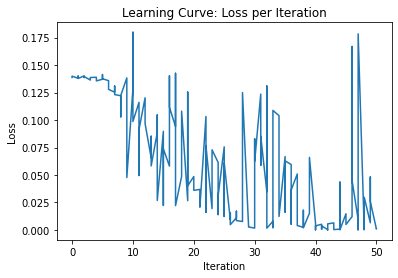

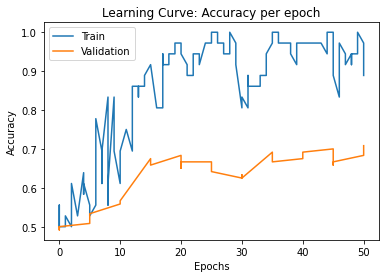

In [ ]:
# Write your code here. Remember to include your results so that we can
# see that your model attains a high training accuracy. 
model_cnn_ch = CNNChannel()
learning_curve_info = train(model_cnn_ch, train_data[:6], valid_data[:6], batch_size=5, learning_rate=0.001, weight_decay=0, max_iters=50, checkpoint_path=None)
plot_learning_curve(*learning_curve_info)

(6, 3, 2, 224, 224, 3)
(18, 448, 224, 3)
(18, 448, 224, 3)
The batch size is: 5
epoch 0: [Val acc 50%, Pos val Acc 100%, Neg val Acc 0%]        [Train acc 50% ,Pos train Acc 100%, Neg train Acc 0% , loss 0.693595]
epoch 1: [Val acc 50%, Pos val Acc 100%, Neg val Acc 0%]        [Train acc 53% ,Pos train Acc 100%, Neg train Acc 6% , loss 0.691801]
epoch 2: [Val acc 50%, Pos val Acc 100%, Neg val Acc 0%]        [Train acc 50% ,Pos train Acc 0%, Neg train Acc 100% , loss 0.692924]
epoch 3: [Val acc 50%, Pos val Acc 100%, Neg val Acc 0%]        [Train acc 67% ,Pos train Acc 89%, Neg train Acc 44% , loss 0.691154]
epoch 4: [Val acc 50%, Pos val Acc 100%, Neg val Acc 0%]        [Train acc 69% ,Pos train Acc 100%, Neg train Acc 39% , loss 0.678110]
epoch 5: [Val acc 56%, Pos val Acc 78%, Neg val Acc 33%]        [Train acc 67% ,Pos train Acc 94%, Neg train Acc 39% , loss 0.691996]
epoch 6: [Val acc 56%, Pos val Acc 78%, Neg val Acc 33%]        [Train acc 58% ,Pos train Acc 39%, Neg train Acc 78

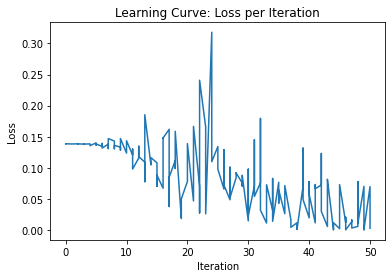

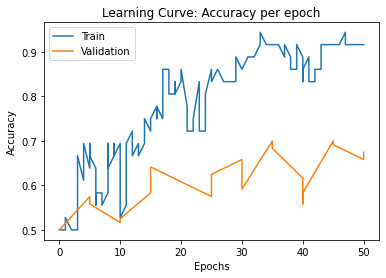

In [ ]:
model_cnn = CNN()
iters, losses, iters_sub, train_accs, val_accs = train(model_cnn, train_data[:6], valid_data[:6], batch_size=5, learning_rate=0.0005, weight_decay=0.0, max_iters=50, checkpoint_path=None)
plot_learning_curve(iters, losses, iters_sub, train_accs, val_accs)

### Part (c) -- 8%

Train your models from Q2(a) and Q2(b). Change the values of a few 
hyperparameters, including the learning rate, batch size, choice of $n$, and 
the kernel size. You do not need to check all values for all hyperparameters. Instead, try to make big changes to see how each change affect your scores.
(try to start with finding a resonable learning rate for each network, that start changing the other parameters, the first network might need bigger $n$ and kernel size)

In this section, explain how you tuned your hyperparameters.

**Write your explanation here:**
First we shall decide on the most optimal learning rate by watching the loss curve and the training curve with batch size of 20, then in order to see the validation behave nicely we will tune the overfitting by changing weight_decay parameter, and then change the batch-szie to see the optimal value, finally we will change the n parameter and see how its behaves.

The model we used here is CNN model
Current learning rate: 0.0001
(30, 3, 2, 224, 224, 3)
(90, 448, 224, 3)
(90, 448, 224, 3)
The batch size is: 20
epoch 0: [Val acc 51%, Pos val Acc 2%, Neg val Acc 100%]        [Train acc 51% ,Pos train Acc 1%, Neg train Acc 100% , loss 0.693045]
epoch 1: [Val acc 51%, Pos val Acc 2%, Neg val Acc 100%]        [Train acc 51% ,Pos train Acc 2%, Neg train Acc 100% , loss 0.692424]
epoch 2: [Val acc 51%, Pos val Acc 2%, Neg val Acc 100%]        [Train acc 53% ,Pos train Acc 94%, Neg train Acc 12% , loss 0.692452]
epoch 3: [Val acc 51%, Pos val Acc 2%, Neg val Acc 100%]        [Train acc 57% ,Pos train Acc 88%, Neg train Acc 27% , loss 0.690491]
epoch 4: [Val acc 51%, Pos val Acc 2%, Neg val Acc 100%]        [Train acc 56% ,Pos train Acc 20%, Neg train Acc 91% , loss 0.692630]
epoch 5: [Val acc 55%, Pos val Acc 23%, Neg val Acc 87%]        [Train acc 57% ,Pos train Acc 27%, Neg train Acc 87% , loss 0.692035]
epoch 6: [Val acc 55%, Pos val Acc 23%, Neg val 

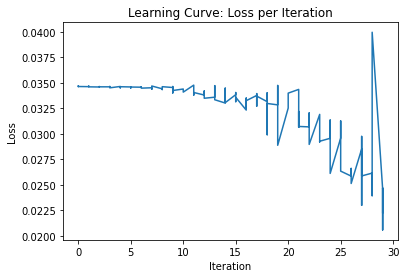

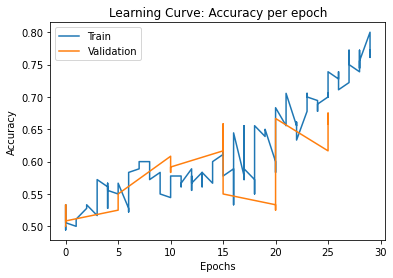

Current learning rate: 0.0005
(30, 3, 2, 224, 224, 3)
(90, 448, 224, 3)
(90, 448, 224, 3)
The batch size is: 20
epoch 0: [Val acc 59%, Pos val Acc 100%, Neg val Acc 18%]        [Train acc 57% ,Pos train Acc 97%, Neg train Acc 17% , loss 1.318555]
epoch 1: [Val acc 59%, Pos val Acc 100%, Neg val Acc 18%]        [Train acc 51% ,Pos train Acc 2%, Neg train Acc 100% , loss 0.889299]
epoch 2: [Val acc 59%, Pos val Acc 100%, Neg val Acc 18%]        [Train acc 59% ,Pos train Acc 26%, Neg train Acc 93% , loss 0.669134]
epoch 3: [Val acc 59%, Pos val Acc 100%, Neg val Acc 18%]        [Train acc 59% ,Pos train Acc 100%, Neg train Acc 19% , loss 0.665611]
epoch 4: [Val acc 59%, Pos val Acc 100%, Neg val Acc 18%]        [Train acc 61% ,Pos train Acc 100%, Neg train Acc 22% , loss 0.667437]
epoch 5: [Val acc 54%, Pos val Acc 42%, Neg val Acc 67%]        [Train acc 61% ,Pos train Acc 34%, Neg train Acc 87% , loss 0.658324]
epoch 6: [Val acc 54%, Pos val Acc 42%, Neg val Acc 67%]        [Train acc 76

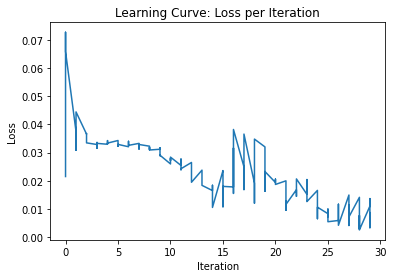

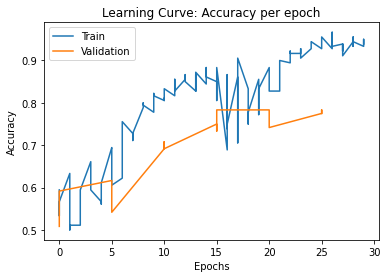

Current learning rate: 0.001
(30, 3, 2, 224, 224, 3)
(90, 448, 224, 3)
(90, 448, 224, 3)
The batch size is: 20
epoch 0: [Val acc 67%, Pos val Acc 100%, Neg val Acc 33%]        [Train acc 78% ,Pos train Acc 100%, Neg train Acc 56% , loss 2.774623]
epoch 1: [Val acc 67%, Pos val Acc 100%, Neg val Acc 33%]        [Train acc 82% ,Pos train Acc 82%, Neg train Acc 82% , loss 0.308251]
epoch 2: [Val acc 67%, Pos val Acc 100%, Neg val Acc 33%]        [Train acc 76% ,Pos train Acc 59%, Neg train Acc 92% , loss 0.386551]
epoch 3: [Val acc 67%, Pos val Acc 100%, Neg val Acc 33%]        [Train acc 77% ,Pos train Acc 69%, Neg train Acc 84% , loss 0.740330]
epoch 4: [Val acc 67%, Pos val Acc 100%, Neg val Acc 33%]        [Train acc 76% ,Pos train Acc 97%, Neg train Acc 54% , loss 0.469806]
epoch 5: [Val acc 72%, Pos val Acc 83%, Neg val Acc 60%]        [Train acc 84% ,Pos train Acc 94%, Neg train Acc 73% , loss 0.436507]
epoch 6: [Val acc 72%, Pos val Acc 83%, Neg val Acc 60%]        [Train acc 86% 

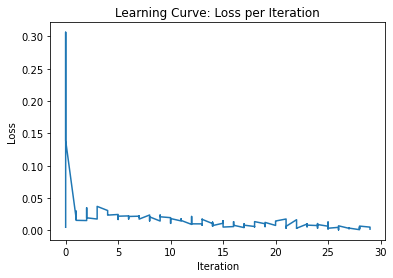

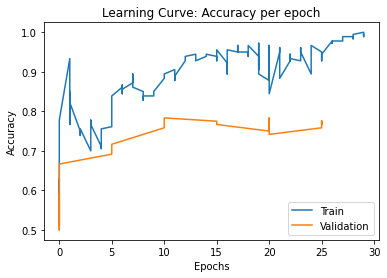

Current learning rate: 0.01
(30, 3, 2, 224, 224, 3)
(90, 448, 224, 3)
(90, 448, 224, 3)
The batch size is: 20
epoch 0: [Val acc 50%, Pos val Acc 100%, Neg val Acc 0%]        [Train acc 50% ,Pos train Acc 100%, Neg train Acc 0% , loss 0.810447]
epoch 1: [Val acc 50%, Pos val Acc 100%, Neg val Acc 0%]        [Train acc 50% ,Pos train Acc 100%, Neg train Acc 0% , loss 0.694655]
epoch 2: [Val acc 50%, Pos val Acc 100%, Neg val Acc 0%]        [Train acc 50% ,Pos train Acc 100%, Neg train Acc 0% , loss 0.693297]
epoch 3: [Val acc 50%, Pos val Acc 100%, Neg val Acc 0%]        [Train acc 50% ,Pos train Acc 0%, Neg train Acc 100% , loss 0.693514]
epoch 4: [Val acc 50%, Pos val Acc 100%, Neg val Acc 0%]        [Train acc 50% ,Pos train Acc 0%, Neg train Acc 100% , loss 0.693297]
epoch 5: [Val acc 50%, Pos val Acc 100%, Neg val Acc 0%]        [Train acc 50% ,Pos train Acc 100%, Neg train Acc 0% , loss 0.693177]
epoch 6: [Val acc 50%, Pos val Acc 100%, Neg val Acc 0%]        [Train acc 50% ,Pos tr

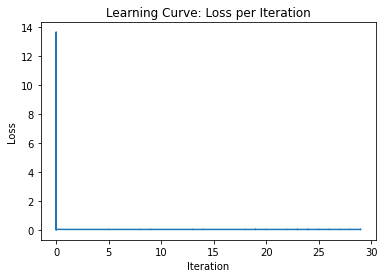

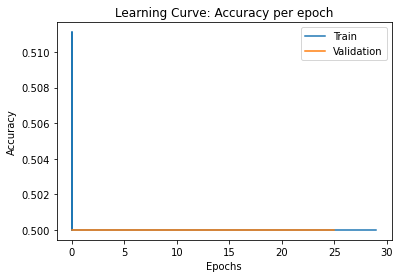

In [ ]:
# Include the training curves for the two models.
model_cnn = CNN()
print('The model we used here is CNN model')
lr =  [0.0001, 0.0005, 0.001, 0.01]
for i in range(len(lr)):
  print(f"Current learning rate: {lr[i]}")
  learning_curve_info = train(model_cnn, train_data[:30], valid_data[:30], batch_size=20, learning_rate=lr[i], weight_decay=0, max_iters=30, checkpoint_path=None)
  plot_learning_curve(*learning_curve_info)

The model we used here is CNNChanel model
(30, 3, 2, 224, 224, 3)
(90, 448, 224, 3)
(90, 448, 224, 3)
The batch size is: 20
epoch 0: [Val acc 57%, Pos val Acc 23%, Neg val Acc 92%]        [Train acc 58% ,Pos train Acc 20%, Neg train Acc 96% , loss 0.692691]
epoch 1: [Val acc 57%, Pos val Acc 23%, Neg val Acc 92%]        [Train acc 54% ,Pos train Acc 8%, Neg train Acc 100% , loss 0.692107]
epoch 2: [Val acc 57%, Pos val Acc 23%, Neg val Acc 92%]        [Train acc 62% ,Pos train Acc 28%, Neg train Acc 96% , loss 0.690774]
epoch 3: [Val acc 57%, Pos val Acc 23%, Neg val Acc 92%]        [Train acc 67% ,Pos train Acc 53%, Neg train Acc 81% , loss 0.690494]
epoch 4: [Val acc 57%, Pos val Acc 23%, Neg val Acc 92%]        [Train acc 68% ,Pos train Acc 61%, Neg train Acc 76% , loss 0.688712]
epoch 5: [Val acc 64%, Pos val Acc 52%, Neg val Acc 77%]        [Train acc 69% ,Pos train Acc 59%, Neg train Acc 80% , loss 0.688020]
epoch 6: [Val acc 64%, Pos val Acc 52%, Neg val Acc 77%]        [Train a

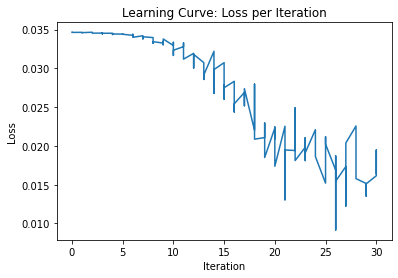

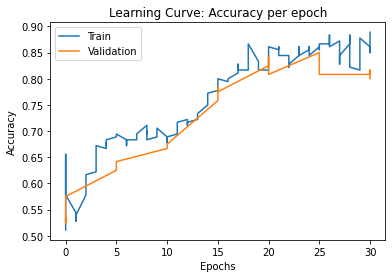

(30, 3, 2, 224, 224, 3)
(90, 448, 224, 3)
(90, 448, 224, 3)
The batch size is: 20
epoch 0: [Val acc 62%, Pos val Acc 35%, Neg val Acc 90%]        [Train acc 62% ,Pos train Acc 28%, Neg train Acc 96% , loss 0.800887]
epoch 1: [Val acc 62%, Pos val Acc 35%, Neg val Acc 90%]        [Train acc 73% ,Pos train Acc 99%, Neg train Acc 47% , loss 0.793822]
epoch 2: [Val acc 62%, Pos val Acc 35%, Neg val Acc 90%]        [Train acc 77% ,Pos train Acc 72%, Neg train Acc 81% , loss 0.675737]
epoch 3: [Val acc 62%, Pos val Acc 35%, Neg val Acc 90%]        [Train acc 82% ,Pos train Acc 91%, Neg train Acc 72% , loss 0.564768]
epoch 4: [Val acc 62%, Pos val Acc 35%, Neg val Acc 90%]        [Train acc 80% ,Pos train Acc 96%, Neg train Acc 64% , loss 0.409506]
epoch 5: [Val acc 82%, Pos val Acc 80%, Neg val Acc 83%]        [Train acc 83% ,Pos train Acc 87%, Neg train Acc 80% , loss 0.327720]
epoch 6: [Val acc 82%, Pos val Acc 80%, Neg val Acc 83%]        [Train acc 83% ,Pos train Acc 77%, Neg train Acc 9

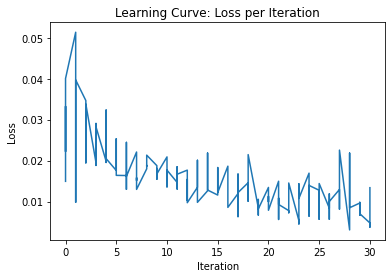

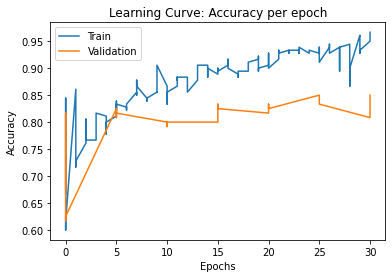

(30, 3, 2, 224, 224, 3)
(90, 448, 224, 3)
(90, 448, 224, 3)
The batch size is: 20
epoch 0: [Val acc 74%, Pos val Acc 97%, Neg val Acc 52%]        [Train acc 74% ,Pos train Acc 100%, Neg train Acc 48% , loss 0.894341]
epoch 1: [Val acc 74%, Pos val Acc 97%, Neg val Acc 52%]        [Train acc 75% ,Pos train Acc 56%, Neg train Acc 94% , loss 0.808292]
epoch 2: [Val acc 74%, Pos val Acc 97%, Neg val Acc 52%]        [Train acc 86% ,Pos train Acc 99%, Neg train Acc 73% , loss 0.343499]
epoch 3: [Val acc 74%, Pos val Acc 97%, Neg val Acc 52%]        [Train acc 88% ,Pos train Acc 98%, Neg train Acc 79% , loss 0.305115]
epoch 4: [Val acc 74%, Pos val Acc 97%, Neg val Acc 52%]        [Train acc 82% ,Pos train Acc 74%, Neg train Acc 90% , loss 0.377997]
epoch 5: [Val acc 83%, Pos val Acc 83%, Neg val Acc 83%]        [Train acc 90% ,Pos train Acc 92%, Neg train Acc 88% , loss 0.343185]
epoch 6: [Val acc 83%, Pos val Acc 83%, Neg val Acc 83%]        [Train acc 93% ,Pos train Acc 97%, Neg train Acc 

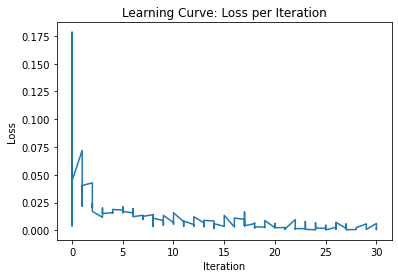

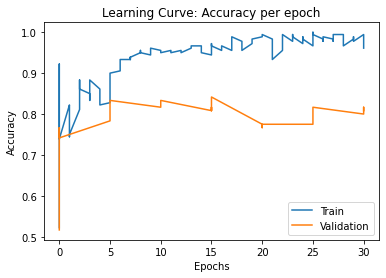

In [ ]:
model_cnn_ch = CNNChannel()
print('The model we used here is CNNChanel model')
lr = [0.0001, 0.0005, 0.001]
for i in range(len(lr)):
  learning_curve_info = train(model_cnn_ch, train_data[:30], valid_data[:30], batch_size=20, learning_rate=lr[i], weight_decay=0, max_iters=30, checkpoint_path=None)
  plot_learning_curve(*learning_curve_info)

 <section>From the graph for changing the learning rate we conclude that the optimal leartning rate for CNN is 0.001, and for CNNChannel is the same<section/>

Now searching the best batch size, from 5,10,30

The model we used here is CNNChanel model
(30, 3, 2, 224, 224, 3)
(90, 448, 224, 3)
(90, 448, 224, 3)
The batch size is: 5
epoch 0: [Val acc 62%, Pos val Acc 45%, Neg val Acc 80%]        [Train acc 64% ,Pos train Acc 56%, Neg train Acc 73% , loss 0.688404]
epoch 1: [Val acc 62%, Pos val Acc 45%, Neg val Acc 80%]        [Train acc 69% ,Pos train Acc 93%, Neg train Acc 46% , loss 0.281634]
epoch 2: [Val acc 62%, Pos val Acc 45%, Neg val Acc 80%]        [Train acc 72% ,Pos train Acc 99%, Neg train Acc 44% , loss 0.449734]
epoch 3: [Val acc 62%, Pos val Acc 45%, Neg val Acc 80%]        [Train acc 66% ,Pos train Acc 100%, Neg train Acc 31% , loss 0.129984]
epoch 4: [Val acc 62%, Pos val Acc 45%, Neg val Acc 80%]        [Train acc 72% ,Pos train Acc 96%, Neg train Acc 48% , loss 0.611975]
epoch 5: [Val acc 88%, Pos val Acc 87%, Neg val Acc 88%]        [Train acc 82% ,Pos train Acc 83%, Neg train Acc 81% , loss 0.308082]
epoch 6: [Val acc 88%, Pos val Acc 87%, Neg val Acc 88%]        [Train a

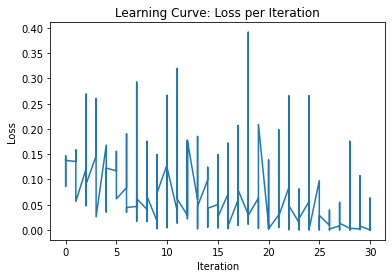

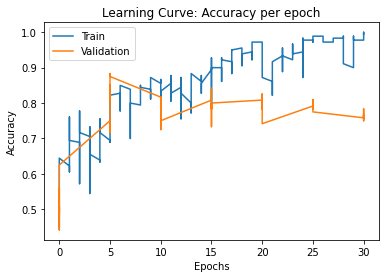

(30, 3, 2, 224, 224, 3)
(90, 448, 224, 3)
(90, 448, 224, 3)
The batch size is: 10
epoch 0: [Val acc 58%, Pos val Acc 72%, Neg val Acc 45%]        [Train acc 64% ,Pos train Acc 80%, Neg train Acc 49% , loss 0.691689]
epoch 1: [Val acc 58%, Pos val Acc 72%, Neg val Acc 45%]        [Train acc 59% ,Pos train Acc 31%, Neg train Acc 87% , loss 0.569890]
epoch 2: [Val acc 58%, Pos val Acc 72%, Neg val Acc 45%]        [Train acc 72% ,Pos train Acc 98%, Neg train Acc 47% , loss 0.547114]
epoch 3: [Val acc 58%, Pos val Acc 72%, Neg val Acc 45%]        [Train acc 73% ,Pos train Acc 96%, Neg train Acc 51% , loss 0.596990]
epoch 4: [Val acc 58%, Pos val Acc 72%, Neg val Acc 45%]        [Train acc 76% ,Pos train Acc 97%, Neg train Acc 56% , loss 0.584598]
epoch 5: [Val acc 82%, Pos val Acc 97%, Neg val Acc 68%]        [Train acc 79% ,Pos train Acc 97%, Neg train Acc 61% , loss 0.461965]
epoch 6: [Val acc 82%, Pos val Acc 97%, Neg val Acc 68%]        [Train acc 67% ,Pos train Acc 100%, Neg train Acc 

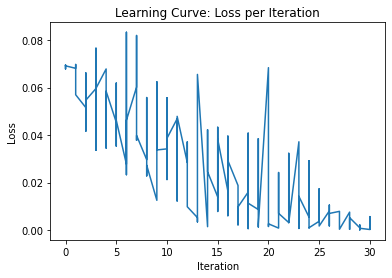

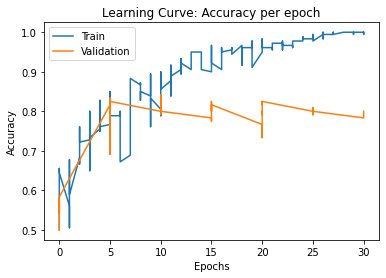

(30, 3, 2, 224, 224, 3)
(90, 448, 224, 3)
(90, 448, 224, 3)
The batch size is: 30
epoch 0: [Val acc 58%, Pos val Acc 30%, Neg val Acc 87%]        [Train acc 59% ,Pos train Acc 36%, Neg train Acc 82% , loss 0.683230]
epoch 1: [Val acc 58%, Pos val Acc 30%, Neg val Acc 87%]        [Train acc 66% ,Pos train Acc 63%, Neg train Acc 68% , loss 0.624889]
epoch 2: [Val acc 58%, Pos val Acc 30%, Neg val Acc 87%]        [Train acc 71% ,Pos train Acc 68%, Neg train Acc 73% , loss 0.572337]
epoch 3: [Val acc 58%, Pos val Acc 30%, Neg val Acc 87%]        [Train acc 76% ,Pos train Acc 76%, Neg train Acc 76% , loss 0.557933]
epoch 4: [Val acc 58%, Pos val Acc 30%, Neg val Acc 87%]        [Train acc 71% ,Pos train Acc 98%, Neg train Acc 43% , loss 0.449807]
epoch 5: [Val acc 72%, Pos val Acc 58%, Neg val Acc 85%]        [Train acc 69% ,Pos train Acc 63%, Neg train Acc 76% , loss 0.493834]
epoch 6: [Val acc 72%, Pos val Acc 58%, Neg val Acc 85%]        [Train acc 77% ,Pos train Acc 98%, Neg train Acc 5

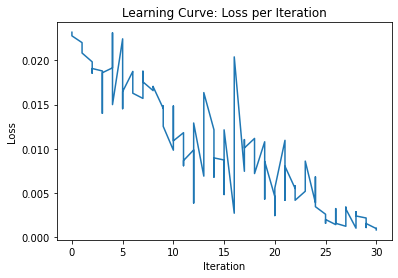

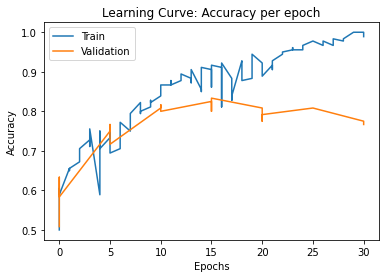

In [ ]:
print('The model we used here is CNNChanel model')
batch_size = [5, 10, 30]
for i in range(len(batch_size)):
  model_cnn_ch = CNNChannel()
  learning_curve_info = train(model_cnn_ch, train_data[:30], valid_data[:30], batch_size=batch_size[i], learning_rate=0.001, weight_decay=0, max_iters=30, checkpoint_path=None)
  plot_learning_curve(*learning_curve_info)

The best ration for CNNChannel of batch size to actual data-set size is 1/3 (meaning 10/30)

The model we used here is CNN model
(30, 3, 2, 224, 224, 3)
(90, 448, 224, 3)
(90, 448, 224, 3)
The batch size is: 5
epoch 0: [Val acc 56%, Pos val Acc 75%, Neg val Acc 37%]        [Train acc 57% ,Pos train Acc 72%, Neg train Acc 41% , loss 0.693039]
epoch 1: [Val acc 56%, Pos val Acc 75%, Neg val Acc 37%]        [Train acc 51% ,Pos train Acc 1%, Neg train Acc 100% , loss 0.694852]
epoch 2: [Val acc 56%, Pos val Acc 75%, Neg val Acc 37%]        [Train acc 60% ,Pos train Acc 72%, Neg train Acc 48% , loss 0.707083]
epoch 3: [Val acc 56%, Pos val Acc 75%, Neg val Acc 37%]        [Train acc 63% ,Pos train Acc 60%, Neg train Acc 67% , loss 0.675579]
epoch 4: [Val acc 56%, Pos val Acc 75%, Neg val Acc 37%]        [Train acc 66% ,Pos train Acc 93%, Neg train Acc 38% , loss 0.541261]
epoch 5: [Val acc 52%, Pos val Acc 30%, Neg val Acc 73%]        [Train acc 54% ,Pos train Acc 29%, Neg train Acc 79% , loss 0.743759]
epoch 6: [Val acc 52%, Pos val Acc 30%, Neg val Acc 73%]        [Train acc 53% 

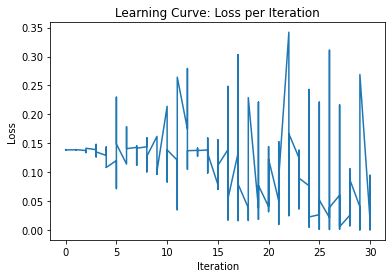

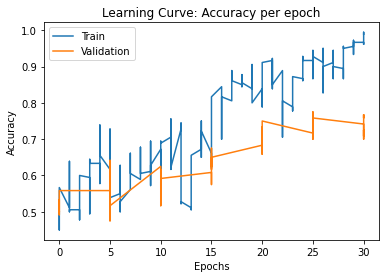

(30, 3, 2, 224, 224, 3)
(90, 448, 224, 3)
(90, 448, 224, 3)
The batch size is: 10
epoch 0: [Val acc 50%, Pos val Acc 0%, Neg val Acc 100%]        [Train acc 50% ,Pos train Acc 0%, Neg train Acc 100% , loss 0.695521]
epoch 1: [Val acc 50%, Pos val Acc 0%, Neg val Acc 100%]        [Train acc 48% ,Pos train Acc 43%, Neg train Acc 52% , loss 0.693037]
epoch 2: [Val acc 50%, Pos val Acc 0%, Neg val Acc 100%]        [Train acc 50% ,Pos train Acc 100%, Neg train Acc 0% , loss 0.693196]
epoch 3: [Val acc 50%, Pos val Acc 0%, Neg val Acc 100%]        [Train acc 50% ,Pos train Acc 62%, Neg train Acc 38% , loss 0.693384]
epoch 4: [Val acc 50%, Pos val Acc 0%, Neg val Acc 100%]        [Train acc 50% ,Pos train Acc 0%, Neg train Acc 100% , loss 0.693175]
epoch 5: [Val acc 50%, Pos val Acc 82%, Neg val Acc 18%]        [Train acc 53% ,Pos train Acc 79%, Neg train Acc 27% , loss 0.692892]
epoch 6: [Val acc 50%, Pos val Acc 82%, Neg val Acc 18%]        [Train acc 49% ,Pos train Acc 94%, Neg train Acc 3

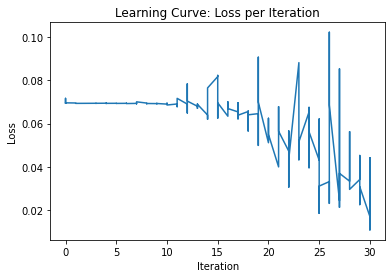

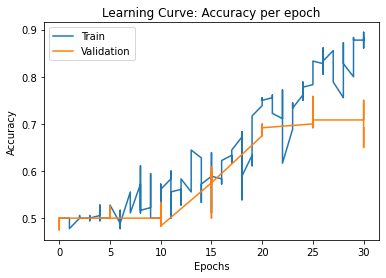

(30, 3, 2, 224, 224, 3)
(90, 448, 224, 3)
(90, 448, 224, 3)
The batch size is: 30
epoch 0: [Val acc 50%, Pos val Acc 0%, Neg val Acc 100%]        [Train acc 50% ,Pos train Acc 0%, Neg train Acc 100% , loss 0.693333]
epoch 1: [Val acc 50%, Pos val Acc 0%, Neg val Acc 100%]        [Train acc 50% ,Pos train Acc 0%, Neg train Acc 100% , loss 0.693179]
epoch 2: [Val acc 50%, Pos val Acc 0%, Neg val Acc 100%]        [Train acc 50% ,Pos train Acc 0%, Neg train Acc 100% , loss 0.693182]
epoch 3: [Val acc 50%, Pos val Acc 0%, Neg val Acc 100%]        [Train acc 53% ,Pos train Acc 80%, Neg train Acc 27% , loss 0.693057]
epoch 4: [Val acc 50%, Pos val Acc 0%, Neg val Acc 100%]        [Train acc 51% ,Pos train Acc 99%, Neg train Acc 2% , loss 0.692950]
epoch 5: [Val acc 56%, Pos val Acc 27%, Neg val Acc 85%]        [Train acc 57% ,Pos train Acc 37%, Neg train Acc 78% , loss 0.692974]
epoch 6: [Val acc 56%, Pos val Acc 27%, Neg val Acc 85%]        [Train acc 55% ,Pos train Acc 34%, Neg train Acc 76

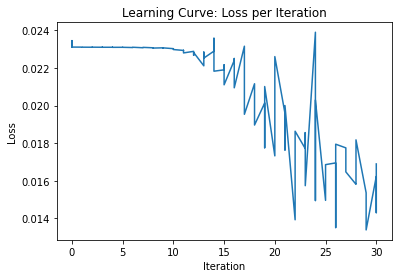

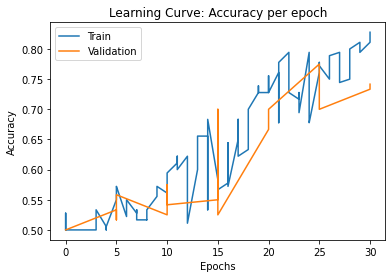

In [ ]:
print('The model we used here is CNN model')
batch_size = [5, 10, 30]
for i in range(len(batch_size)):
  model_cnn = CNN()
  learning_curve_info = train(model_cnn, train_data[:30], valid_data[:30], batch_size=batch_size[i], learning_rate=0.001, weight_decay=0, max_iters=30, checkpoint_path=None)
  plot_learning_curve(*learning_curve_info)

The best batch size combination:
CNN -16% of the size of the dataset
CNNChannel - 30% of the size of the dataset

Lets change n factor and see how it bejaves, lets choose n=10

(30, 3, 2, 224, 224, 3)
(90, 448, 224, 3)
(90, 448, 224, 3)
The batch size is: 10
epoch 0: [Val acc 67%, Pos val Acc 63%, Neg val Acc 70%]        [Train acc 73% ,Pos train Acc 80%, Neg train Acc 66% , loss 0.558044]
epoch 1: [Val acc 67%, Pos val Acc 63%, Neg val Acc 70%]        [Train acc 81% ,Pos train Acc 97%, Neg train Acc 66% , loss 0.497279]
epoch 2: [Val acc 67%, Pos val Acc 63%, Neg val Acc 70%]        [Train acc 84% ,Pos train Acc 84%, Neg train Acc 83% , loss 0.214141]
epoch 3: [Val acc 67%, Pos val Acc 63%, Neg val Acc 70%]        [Train acc 86% ,Pos train Acc 91%, Neg train Acc 81% , loss 0.145928]
epoch 4: [Val acc 67%, Pos val Acc 63%, Neg val Acc 70%]        [Train acc 84% ,Pos train Acc 89%, Neg train Acc 80% , loss 0.321919]
epoch 5: [Val acc 81%, Pos val Acc 93%, Neg val Acc 68%]        [Train acc 86% ,Pos train Acc 98%, Neg train Acc 73% , loss 0.439147]
epoch 6: [Val acc 81%, Pos val Acc 93%, Neg val Acc 68%]        [Train acc 86% ,Pos train Acc 96%, Neg train Acc 7

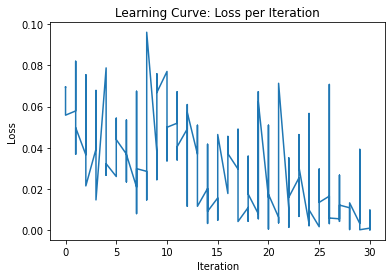

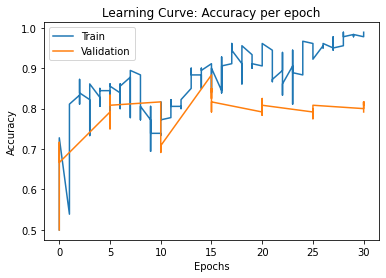

In [ ]:
model_cnn_ch = CNNChannel(n=10)
learning_curve_info = train(model_cnn_ch, train_data[:30], valid_data[:30], batch_size=10, learning_rate=0.001, weight_decay=0, max_iters=30, checkpoint_path=None)
plot_learning_curve(*learning_curve_info)

In [ ]:
model_cnn = CNN(n=10)
learning_curve_info = train(model_cnn, train_data[:30], valid_data[:30], batch_size=5, learning_rate=0.001, weight_decay=0, max_iters=30, checkpoint_path=None)
plot_learning_curve(*learning_curve_info)

(30, 3, 2, 224, 224, 3)
(90, 448, 224, 3)
(90, 448, 224, 3)
The batch size is: 5
epoch 0: [Val acc 50%, Pos val Acc 100%, Neg val Acc 0%]        [Train acc 49% ,Pos train Acc 99%, Neg train Acc 0% , loss 0.693847]
epoch 1: [Val acc 50%, Pos val Acc 100%, Neg val Acc 0%]        [Train acc 51% ,Pos train Acc 46%, Neg train Acc 57% , loss 0.693506]
epoch 2: [Val acc 50%, Pos val Acc 100%, Neg val Acc 0%]        [Train acc 49% ,Pos train Acc 76%, Neg train Acc 23% , loss 0.693233]
epoch 3: [Val acc 50%, Pos val Acc 100%, Neg val Acc 0%]        [Train acc 58% ,Pos train Acc 73%, Neg train Acc 42% , loss 0.694936]
epoch 4: [Val acc 50%, Pos val Acc 100%, Neg val Acc 0%]        [Train acc 54% ,Pos train Acc 19%, Neg train Acc 90% , loss 0.692023]
epoch 5: [Val acc 49%, Pos val Acc 8%, Neg val Acc 90%]        [Train acc 49% ,Pos train Acc 12%, Neg train Acc 87% , loss 0.699391]
epoch 6: [Val acc 49%, Pos val Acc 8%, Neg val Acc 90%]        [Train acc 53% ,Pos train Acc 98%, Neg train Acc 8% , 

KeyboardInterrupt: ignored

(30, 3, 2, 224, 224, 3)
(90, 448, 224, 3)
(90, 448, 224, 3)
The batch size is: 10
epoch 0: [Val acc 52%, Pos val Acc 48%, Neg val Acc 55%]        [Train acc 57% ,Pos train Acc 56%, Neg train Acc 59% , loss 0.692313]
epoch 1: [Val acc 52%, Pos val Acc 48%, Neg val Acc 55%]        [Train acc 59% ,Pos train Acc 32%, Neg train Acc 87% , loss 0.686852]
epoch 2: [Val acc 52%, Pos val Acc 48%, Neg val Acc 55%]        [Train acc 67% ,Pos train Acc 72%, Neg train Acc 61% , loss 0.681137]
epoch 3: [Val acc 52%, Pos val Acc 48%, Neg val Acc 55%]        [Train acc 60% ,Pos train Acc 38%, Neg train Acc 82% , loss 0.650480]
epoch 4: [Val acc 52%, Pos val Acc 48%, Neg val Acc 55%]        [Train acc 64% ,Pos train Acc 73%, Neg train Acc 56% , loss 0.670385]
epoch 5: [Val acc 72%, Pos val Acc 68%, Neg val Acc 75%]        [Train acc 67% ,Pos train Acc 71%, Neg train Acc 62% , loss 0.694272]
epoch 6: [Val acc 72%, Pos val Acc 68%, Neg val Acc 75%]        [Train acc 72% ,Pos train Acc 92%, Neg train Acc 5

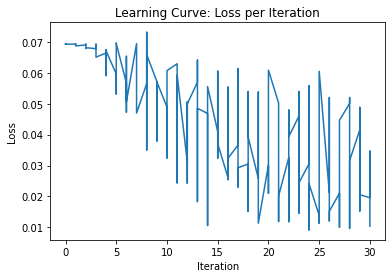

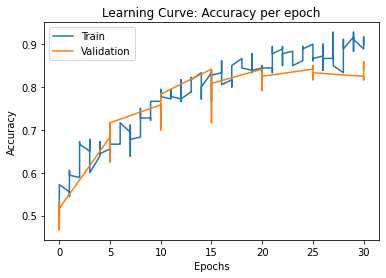

In [ ]:
model_cnn_ch = CNNChannel(n=10)
learning_curve_info = train(model_cnn_ch, train_data[:30], valid_data[:30], batch_size=10, learning_rate=0.0001, weight_decay=0, max_iters=30, checkpoint_path=None)
plot_learning_curve(*learning_curve_info)

### Part (d) -- 4%

Include your training curves for the **best** models from each of Q2(a) and Q2(b).
These are the models that you will use in Question 4.

In [11]:
# Include the training curves for the two models.
import threading
model_cnn_ch = CNNChannel(n=10)
model_cnn = CNN()
checkpoint_path_1 = "/content/gdrive/My Drive/Intro_to_Deep_Learning/assignment3/CNN_epoch-{}.pk"
checkpoint_path_2 = "/content/gdrive/My Drive/Intro_to_Deep_Learning/assignment3/CNNChannel_epoch-{}.pk"
t1=threading.Thread(target=train, args=(model_cnn_ch, train_data, valid_data, 30, 0.001, 0.0001, 30, checkpoint_path_2,))
t2=threading.Thread(target=train, args=(model_cnn, train_data, valid_data, 15, 0.001, 0.0, 30, checkpoint_path_1,))  

t1.start()
t2.start()

t1.join()
t2.join()
print("Finished")

(92, 3, 2, 224, 224, 3)
(276, 448, 224, 3)
(276, 448, 224, 3)
The batch size is: 15
(92, 3, 2, 224, 224, 3)
(276, 448, 224, 3)
(276, 448, 224, 3)
The batch size is: 30
epoch 0: [Val acc 57%, Pos val Acc 17%, Neg val Acc 98%]        [Train acc 59% ,Pos train Acc 20%, Neg train Acc 98% , loss 0.649152]
epoch 0: [Val acc 60%, Pos val Acc 68%, Neg val Acc 52%]        [Train acc 58% ,Pos train Acc 63%, Neg train Acc 54% , loss 0.687852]
epoch 1: [Val acc 57%, Pos val Acc 17%, Neg val Acc 98%]        [Train acc 77% ,Pos train Acc 62%, Neg train Acc 92% , loss 0.438747]
epoch 1: [Val acc 60%, Pos val Acc 68%, Neg val Acc 52%]        [Train acc 68% ,Pos train Acc 87%, Neg train Acc 49% , loss 0.740774]
epoch 2: [Val acc 57%, Pos val Acc 17%, Neg val Acc 98%]        [Train acc 82% ,Pos train Acc 92%, Neg train Acc 71% , loss 0.337961]
epoch 2: [Val acc 60%, Pos val Acc 68%, Neg val Acc 52%]        [Train acc 73% ,Pos train Acc 69%, Neg train Acc 77% , loss 0.631461]
epoch 3: [Val acc 57%, Pos v

## Question 4. Testing (15%)

### Part (a) -- 7%

Report the test accuracies of your **single best** model,
separately for the two test sets.
Do this by choosing the  model
architecture that produces the best validation accuracy. For instance,
if your model attained the
best validation accuracy in epoch 12, then the weights at epoch 12 is what you should be using
to report the test accuracy.

In [20]:
# Write your code here. Make sure to include the test accuracy in your report
#model.load_state_dict(torch.load(''))
pos_test_m_acc, neg_testm_acc = get_accuracy(model_cnn_ch, test_m_data)
pos_test_w_acc, neg_testw_acc = get_accuracy(model_cnn_ch, test_w_data)
test_m_acc = (pos_test_m_acc + neg_testm_acc)/2
test_w_acc = (pos_test_w_acc + neg_testw_acc)/2
pos_test_acc = (pos_test_m_acc + pos_test_w_acc)/2
neg_test_acc = (neg_testm_acc + neg_testw_acc)/2
test_acc = (pos_test_acc + neg_test_acc)/2
print("Male total test accuracy: %.0f%%, Positive acc: %.0f%%, Negative acc: %.0f%%" % (test_m_acc * 100, pos_test_m_acc * 100, neg_testm_acc * 100))
print("Female total test accuracy: %.0f%%, Positive acc: %.0f%%, Negative acc: %.0f%%" % (test_w_acc * 100, pos_test_w_acc * 100, neg_testw_acc * 100))
print("Total test accuracy: %.0f%%, Positive acc: %.0f%%, Negative acc: %.0f%%" % (test_acc * 100, pos_test_acc * 100, neg_test_acc * 100))

Male total test accuracy: 78%, Positive acc: 87%, Negative acc: 70%
Female total test accuracy: 87%, Positive acc: 93%, Negative acc: 80%
Total test accuracy: 82%, Positive acc: 90%, Negative acc: 75%


### Part (b) -- 4%

Display one set of men's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the men's shoes test set,
display one set of inputs that your model classified incorrectly.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


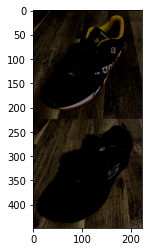

In [17]:
model_cnn_ch.eval()
n = test_m_data.shape[0]

data_pos = generate_same_pair(test_m_data)      # should have shape [n * 3, 448, 224, 3]
data_neg = generate_different_pair(test_m_data) # should have shape [n * 3, 448, 224, 3]

# pos_correct = 0
# for i in range(0, len(data_pos), batch_size):
#     xs = torch.Tensor(data_pos[i:i+batch_size]).transpose(1, 3)
#     # print(xs)
#     zs = model(xs)
#     pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
#     pred = pred.detach().numpy()
#     pos_correct += (pred == 1).sum()
    
neg_correct = 0
for i in range(0, len(data_neg), 64):
    xs = torch.Tensor(data_neg[i:i+50]).transpose(1, 3)
    zs = model_cnn_ch(xs)
    pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
    pred = pred.detach().numpy()
    neg_correct += (pred == 0).sum()
    plt.imshow(data_neg[i])


### Part (c) -- 4%

Display one set of women's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the women's shoes test set,
display one set of inputs that your model classified incorrectly.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


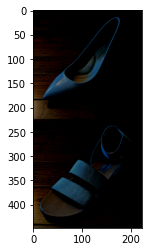

In [19]:
model_cnn_ch.eval()
n = test_w_data.shape[0]

data_pos = generate_same_pair(test_w_data)      # should have shape [n * 3, 448, 224, 3]
data_neg = generate_different_pair(test_w_data) # should have shape [n * 3, 448, 224, 3]


pos_correct = 0
for i in range(0, len(data_neg), 64):
    xs = torch.Tensor(data_pos[i:i+50]).transpose(1, 3)
    zs = model_cnn_ch(xs)
    pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
    pred = pred.detach().numpy()
    pos_correct += (pred == 1).sum()
    plt.imshow(data_pos[i])

neg_correct = 0
for i in range(0, len(data_neg), 64):
    xs = torch.Tensor(data_neg[i:i+50]).transpose(1, 3)
    zs = model_cnn_ch(xs)
    pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
    pred = pred.detach().numpy()
    neg_correct += (pred == 0).sum()
    plt.imshow(data_neg[i])